In [6]:
#dataset
!git clone https://github.com/defcom17/NSL_KDD

#visualisation
!pip install yellowbrick
!pip install tslearn

fatal: destination path 'NSL_KDD' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.2 MB/s eta 0:00:00


In [48]:
import time
from math import e

import numpy as np
import pandas as pd
from sklearn import preprocessing
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


from keras.models import Model
from keras.layers import Input, Dense

from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from keras.layers import DepthwiseConv2D, Reshape, Flatten



from yellowbrick.features import Rank1D, Rank2D, PCADecomposition
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import load_model, save_model


In [37]:
def preprocess_data(path, normal_values, time_steps):
  col = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
          "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
          "is_host_login","is_guest_login","count","srv_count","serror_rate",
          "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]


  df = pd.read_csv(path, header=None, names = col)

  df = df[df['label'].isin(normal_values)]

  label_counts = df['label'].value_counts()

  for label, count in label_counts.items():
      print(f"{label} -> {count}")

  print(np.unique(df.label.values))

  df.describe()

  df.protocol_type = preprocessing.LabelEncoder().fit_transform(df["protocol_type"])
  df.service = preprocessing.LabelEncoder().fit_transform(df["service"])
  df.flag = preprocessing.LabelEncoder().fit_transform(df["flag"])

  good_df = df[df['label'] == 'normal']
  bad_df = df[df['label'] != 'normal']



  print(good_df.shape)
  print(bad_df.shape)

  df.label = preprocessing.LabelEncoder().fit_transform(df["label"])
  good_df.label = preprocessing.LabelEncoder().fit_transform(good_df["label"])
  bad_df.label = preprocessing.LabelEncoder().fit_transform(bad_df["label"])

  X = df.drop(columns=["label", "difficulty"]).values
  y = df.label.values

  X, y = create_sequences(X, y, time_steps)

  positive_X, positive_y = create_sequences(good_df[col].values, good_df.label.values, time_steps)

  negative_X, negative_y = create_sequences(bad_df[col].values, bad_df.label.values, time_steps)

  print(np.unique(y))

  return X, y, positive_X, positive_y, negative_X, negative_y


def create_sequences(data, labels, time_steps):
  sequences = []
  seq_labels = []
  for i in range(len(data) - time_steps + 1):
    sequences.append(data[i:i + time_steps])
    seq_labels.append(labels[i + time_steps - 1])  # Label of the last event in the window
  return np.array(sequences), np.array(seq_labels)

In [38]:
train_path = "NSL_KDD/KDDTrain+.csv"
test_path = "NSL_KDD/KDDTest+.csv"

valid_classes = ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep',
 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf',
 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy', 'teardrop',
 'warezclient', 'warezmaster']

tracked_length = 12

X_train, y_train, positive_X_train, positive_y_train, negative_X_train, negative_y_train = preprocess_data(train_path, valid_classes, tracked_length)

print("Temporal Data Shape:", X_train.shape)  # (num_sequences, time_steps, num_features)
print("Labels Shape:", y_train.shape)

print('==========================================================')

X_test, y_test, positive_X_test, positive_y_test, negative_X_test, negative_y_test = preprocess_data(test_path, valid_classes, tracked_length)

print("Temporal Data Shape:", X_test.shape)  # (num_sequences, time_steps, num_features)
print("Labels Shape:", y_test.shape)


normal -> 67343
neptune -> 41214
satan -> 3633
ipsweep -> 3599
portsweep -> 2931
smurf -> 2646
nmap -> 1493
back -> 956
teardrop -> 892
warezclient -> 890
pod -> 201
guess_passwd -> 53
buffer_overflow -> 30
warezmaster -> 20
land -> 18
imap -> 11
rootkit -> 10
loadmodule -> 9
ftp_write -> 8
multihop -> 7
phf -> 4
perl -> 3
spy -> 2
['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']
(67343, 43)
(58630, 43)


<ipython-input-37-e1132828ad21>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_df.label = preprocessing.LabelEncoder().fit_transform(good_df["label"])
<ipython-input-37-e1132828ad21>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_df.label = preprocessing.LabelEncoder().fit_transform(bad_df["label"])


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Temporal Data Shape: (125962, 12, 41)
Labels Shape: (125962,)
normal -> 9710
neptune -> 4657
guess_passwd -> 1231
warezmaster -> 944
satan -> 735
smurf -> 665
back -> 359
portsweep -> 157
ipsweep -> 141
nmap -> 73
pod -> 41
buffer_overflow -> 20
multihop -> 18
rootkit -> 13
teardrop -> 12
land -> 7
ftp_write -> 3
perl -> 2
loadmodule -> 2
phf -> 2
imap -> 1
['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'teardrop' 'warezmaster']
(9710, 43)
(9083, 43)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Temporal Data Shape: (18782, 12, 41)
Labels Shape: (18782,)


<ipython-input-37-e1132828ad21>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_df.label = preprocessing.LabelEncoder().fit_transform(good_df["label"])
<ipython-input-37-e1132828ad21>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_df.label = preprocessing.LabelEncoder().fit_transform(bad_df["label"])


In [39]:
# scale 3-D
scaler = TimeSeriesScalerMeanVariance()

X_scaled_train = scaler.fit_transform(positive_X_train)
X_scaled_test = scaler.transform(positive_X_test)

In [46]:
# AUTOENCODER WITH DEPTHWISE CONVOLUTIONS

encoding_dim = 10

time_steps = X_scaled_train.shape[1]
num_features = X_scaled_train.shape[2]

input_layer = Input(shape=(time_steps, num_features))

encoder = DepthwiseConv2D(kernel_size=(3, 1), strides=(1, 1), activation='relu', padding='same')(Reshape((time_steps, num_features, 1))(input_layer))
encoder = DepthwiseConv2D(kernel_size=(3, 1), strides=(1, 1), activation='relu', padding='same')(encoder)
encoder = Flatten()(encoder)
bottleneck = Dense(encoding_dim, activation='relu')(encoder)  # Bottleneck

decoder = Dense(time_steps * num_features, activation='relu')(bottleneck)
decoder = Reshape((time_steps, num_features))(decoder)
decoder = Conv1D(64, kernel_size=3, activation='relu', padding='same')(decoder)
decoder = Conv1D(num_features, kernel_size=3, activation='sigmoid', padding='same')(decoder)

convDV_autoencoder = Model(inputs=input_layer, outputs=decoder)
convDV_autoencoder.compile(optimizer='adam', loss='mse')

convDV_autoencoder.fit(X_scaled_train, X_scaled_train, epochs=50, batch_size=32, validation_data=(X_scaled_test, X_scaled_test))


Epoch 1/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.5309 - val_loss: 0.4259
Epoch 2/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5007 - val_loss: 0.4023
Epoch 3/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.4757 - val_loss: 0.3970
Epoch 4/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4682 - val_loss: 0.3916
Epoch 5/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.4634 - val_loss: 0.3904
Epoch 6/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.4597 - val_loss: 0.3877
Epoch 7/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4571 - val_loss: 0.3856
Epoch 8/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.4563 - val_loss: 0.3855
Epoch 9/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4544 - val_loss: 0.3848
Epoch 10/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4530 - val_loss: 0.3838
Epoch 11/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.4515 - val_loss: 0.3840
Epoch 12/50
2105/2105 ━━━━━

In [41]:
# AUTOENCODER WITH LINEAR CONVOLUTIONAL LAYERS

input_layer = Input(shape=(time_steps, num_features))
print(input_layer.shape)

encoder = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
encoder = MaxPooling1D(pool_size=2, padding='same')(encoder)
encoder = Conv1D(32, kernel_size=3, activation='relu', padding='same')(encoder)
encoder = MaxPooling1D(pool_size=2, padding='same')(encoder)
bottleneck = Conv1D(encoding_dim, kernel_size=3, activation='relu', padding='same')(encoder)

decoder = UpSampling1D(size=2)(bottleneck)
decoder = Conv1D(32, kernel_size=3, activation='relu', padding='same')(decoder)
decoder = UpSampling1D(size=2)(decoder)
decoder = Conv1D(num_features, kernel_size=3, activation='sigmoid', padding='same')(decoder)

conv1d_autoencoder = Model(inputs=input_layer, outputs=decoder)
conv1d_autoencoder.compile(optimizer='adam', loss='mse')

conv1d_autoencoder.fit(X_scaled_train, X_scaled_train, epochs=50, batch_size=32, validation_data=(X_scaled_test, X_scaled_test))


(None, 12, 43)
Epoch 1/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.5274 - val_loss: 0.3908
Epoch 2/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4591 - val_loss: 0.3587
Epoch 3/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4216 - val_loss: 0.3513
Epoch 4/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4112 - val_loss: 0.3479
Epoch 5/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.4063 - val_loss: 0.3453
Epoch 6/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4030 - val_loss: 0.3428
Epoch 7/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4002 - val_loss: 0.3410
Epoch 8/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.3985 - val_loss: 0.3398
Epoch 9/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3963 - val_loss: 0.3379
Epoch 10/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.3948 - val_loss: 0.3376
Epoch 11/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.3934 - val_loss: 0.3357
Epoch 12/50

In [45]:
# COMBINED AUTOENCODER

input_layer = Input(shape=(time_steps, num_features))

encoder = DepthwiseConv2D(kernel_size=(3, 1), activation='relu', padding='same')(Reshape((time_steps, num_features, 1))(input_layer))
encoder = DepthwiseConv2D(kernel_size=(3, 1), activation='relu', padding='same')(encoder)
encoder = Flatten()(encoder)
bottleneck = Dense(encoding_dim, activation='relu')(encoder)  # Bottleneck

decoder = Dense(time_steps * num_features, activation='relu')(bottleneck)
decoder = Reshape((time_steps, num_features))(decoder)
#decoder = UpSampling1D(size=2)(decoder)
decoder = Conv1D(64, kernel_size=3, activation='relu', padding='same')(decoder)
decoder = Conv1D(num_features, kernel_size=3, activation='sigmoid', padding='same')(decoder)

combined_autoencoder = Model(inputs=input_layer, outputs=decoder)
combined_autoencoder.compile(optimizer='adam', loss='mse')


combined_autoencoder.fit(X_scaled_train, X_scaled_train, epochs=50, batch_size=32, validation_data=(X_scaled_test, X_scaled_test))


Epoch 1/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5323 - val_loss: 0.4259
Epoch 2/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.5055 - val_loss: 0.4103
Epoch 3/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.4863 - val_loss: 0.4067
Epoch 4/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.4820 - val_loss: 0.4046
Epoch 5/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4776 - val_loss: 0.4009
Epoch 6/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.4745 - val_loss: 0.3994
Epoch 7/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4734 - val_loss: 0.3988
Epoch 8/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.4715 - val_loss: 0.3960
Epoch 9/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.4686 - val_loss: 0.3931
Epoch 10/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4646 - val_loss: 0.3914
Epoch 11/50
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4622 - val_loss: 0.3906
Epoch 12/50
2105/2105 ━━━━

<ipython-input-5-2431c54dffff>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('plasma', len(unique_labels))


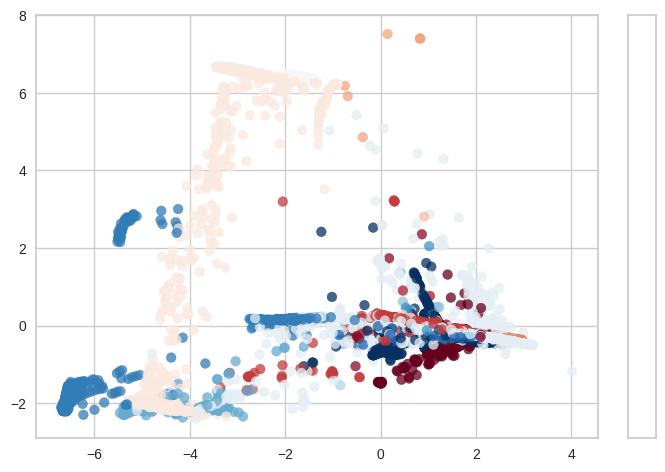

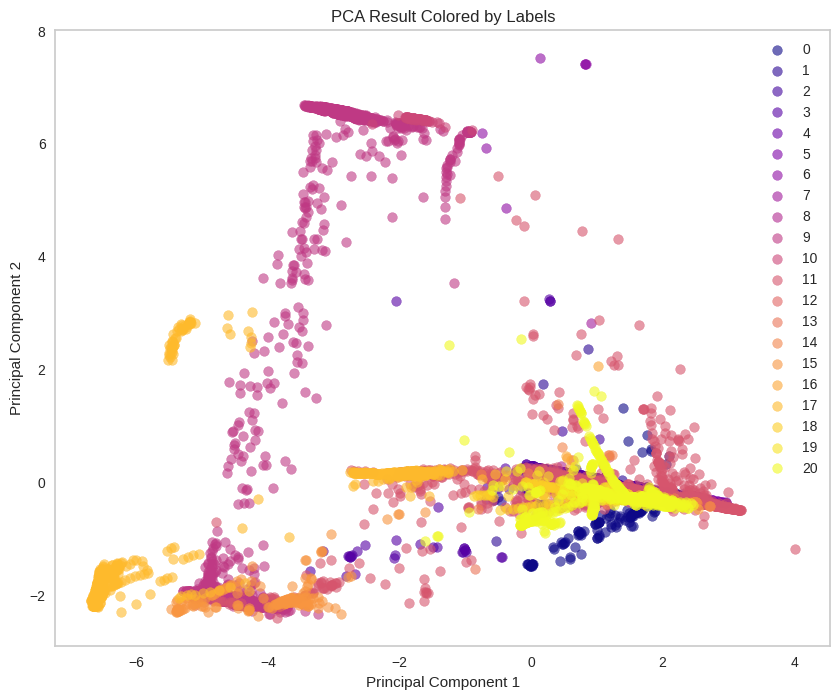

In [ ]:
# VISUALIZE DATA


visualizer = PCADecomposition(scale=True, center=False)

X_pca = visualizer.fit_transform(X_test, y_test)

plt.figure(figsize=(10, 8))

unique_labels = np.unique(y_test)
colors = plt.cm.get_cmap('plasma', len(unique_labels))


for i, label in enumerate(unique_labels):
    plt.scatter(X_pca[y_test == label, 0], X_pca[y_test == label, 1],
                label=label, color=colors(i), alpha=0.6)

plt.title('PCA Result Colored by Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()


plt.show()



AUTOENCODER WITH CONVOLUTIONAL LAYERS

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.007646032647038246
1.965075718017106e-26
1.8779055143509862
Average MSE for good samples:  0.3784867133627245


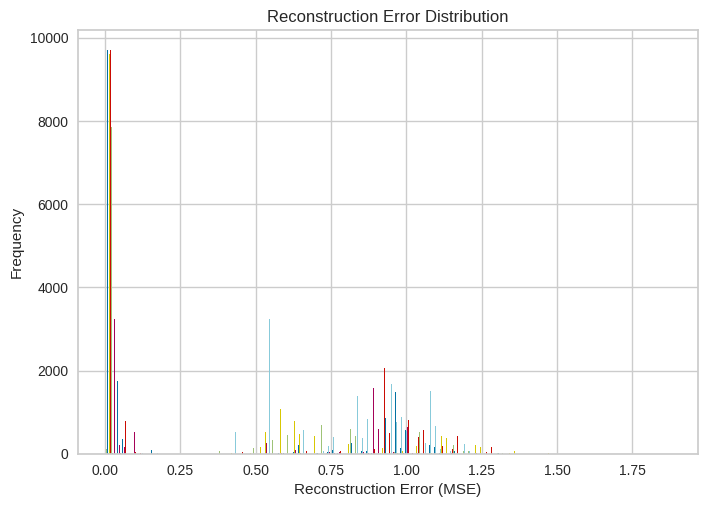

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.915764486080453
9.744416573967601e-32
2.09380565364062
Average MSE for bad samples:  0.6671295749862544


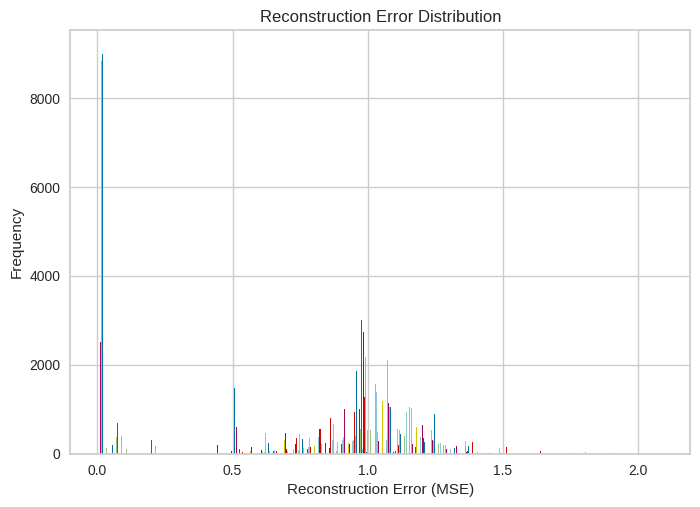


AUTOENCODER WITH DEPTHWISE CONVOLUTIONS

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.006507757798299148
0.0
1.898624828480335
Average MSE for good samples:  0.329601973845994


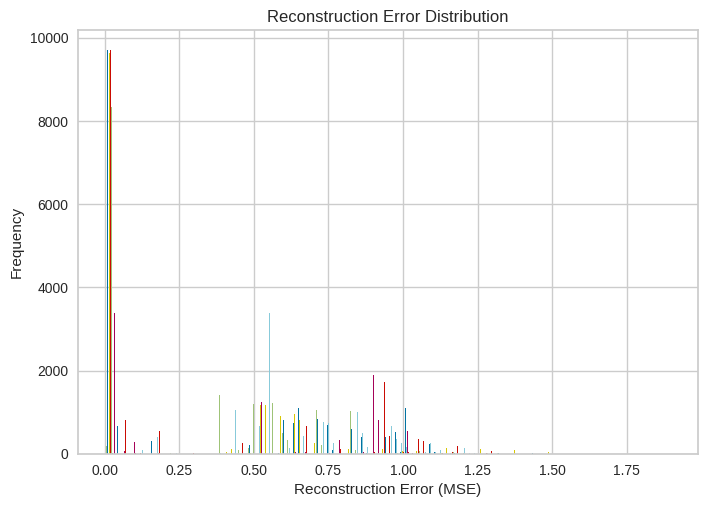

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.7816467676496186
0.0
2.1530665521928456
Average MSE for bad samples:  0.6205952217269062


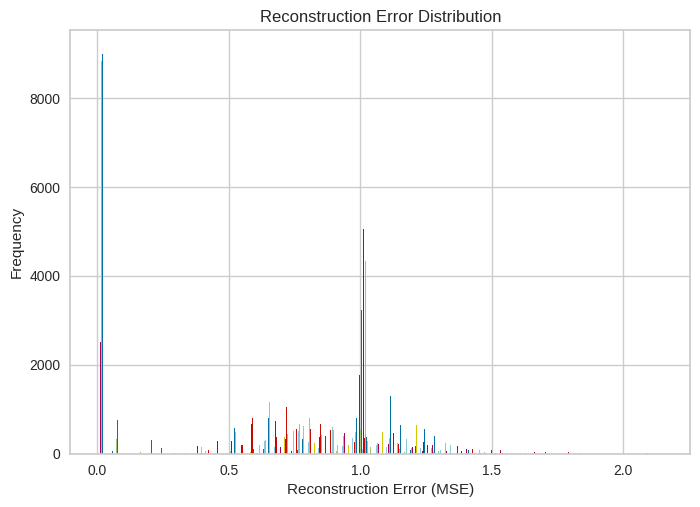


COMBINED AUTOENCODER

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.004243662948842572
4.2015094795317586e-33
1.7444468739555183
Average MSE for good samples:  0.38259212782684743


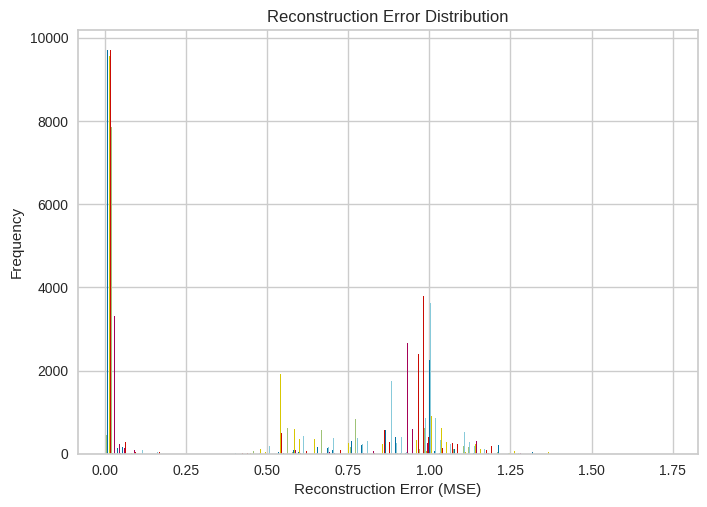

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.8992265355099875
3.661600401121978e-41
2.090932842350426
Average MSE for bad samples:  0.6493558120967923


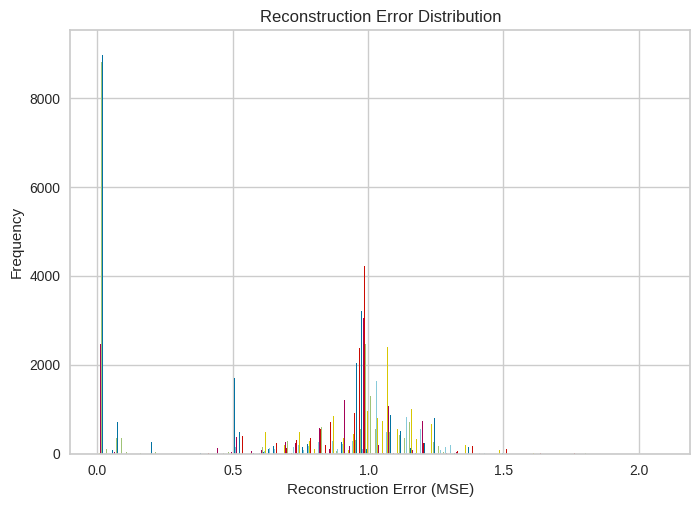

In [57]:
# EVALUATION FOR AUTOENCODER

def evaluate_precision(autoencoder, positive_X, negative_X):

    positive_X = scaler.fit_transform(positive_X)
    pos_X_pred = autoencoder.predict(positive_X)

    mse = np.mean(np.power(positive_X - pos_X_pred, 2), axis=1)
    print(np.median(mse))
    print(np.min(mse))
    print(np.max(mse))

    print("Average MSE for good samples: ", np.mean(mse))

    plt.hist(mse, bins=50)
    plt.xlabel("Reconstruction Error (MSE)")
    plt.ylabel("Frequency")
    plt.title("Reconstruction Error Distribution")
    plt.show()

    X_bad = scaler.fit_transform(negative_X)
    X_bad_pred = autoencoder.predict(X_bad)

    mse = np.mean(np.power(X_bad - X_bad_pred, 2), axis=1)
    print(np.median(mse))
    print(np.min(mse))
    print(np.max(mse))
    print("Average MSE for bad samples: ", np.mean(mse))

    plt.hist(mse, bins=50)
    plt.xlabel("Reconstruction Error (MSE)")
    plt.ylabel("Frequency")
    plt.title("Reconstruction Error Distribution")
    plt.show()

def evaluate_speed(autoencoder, test_data):
  start_time_0 = time.time()
  test_data = scaler.fit_transform(positive_X_test)

  start_time = time.time()

  predictions = autoencoder.predict(test_data)

  end_time = time.time()

  total_time = (end_time - start_time) / len(test_data) * 1000

  withPreproc_time = (end_time - start_time_0) / len(test_data) * 1000

  #print(total_time, withPreproc_time)

  return total_time, withPreproc_time

print("\nAUTOENCODER WITH CONVOLUTIONAL LAYERS\n")
evaluate_precision(convDV_autoencoder, positive_X_test, negative_X_test)

print("\nAUTOENCODER WITH DEPTHWISE CONVOLUTIONS\n")
evaluate_precision(conv1d_autoencoder, positive_X_test, negative_X_test)

print("\nCOMBINED AUTOENCODER\n")
evaluate_precision(combined_autoencoder, positive_X_test, negative_X_test)

In [54]:
# CONF MATRIX FOR AUTOENCODER

def confusion_matrix(autoencoder, threshold, positive_X, negative_X):

  positive_X = scaler.fit_transform(positive_X)
  pos_X_pred = autoencoder.predict(positive_X)

  mse = np.mean(np.power(positive_X - pos_X_pred, 2), axis=(1, 2))

  y_pred = np.where(mse > threshold, 1, 0)
  y_true = np.zeros(len(y_pred))

  TN = np.sum((y_pred == 0) & (y_true == 0))
  FP = np.sum((y_pred == 1) & (y_true == 0))

  negative_X = scaler.fit_transform(negative_X)
  neg_X_pred = autoencoder.predict(negative_X)

  mse = np.mean(np.power(negative_X - neg_X_pred, 2), axis=(1, 2))

  y_pred = np.where(mse > threshold, 1, 0)
  y_true = np.ones(len(y_pred))

  FN = np.sum((y_pred == 0) & (y_true == 1))
  TP = np.sum((y_pred == 1) & (y_true == 1))


  return TP, TN, FP, FN

def calculate_precision(tp, tn, fp, fn):
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * (precision * recall) / (precision + recall)

  return precision, recall, f1_score


In [58]:
print("\nAUTOENCODER WITH CONVOLUTIONAL LAYERS\n")

TP, TN, FP, FN = confusion_matrix(convDV_autoencoder, 0.5, positive_X_test, negative_X_test)
total_time, withPreproc_time = evaluate_speed(convDV_autoencoder, positive_X_test)
print("TP: ", str(TP), " | TN: ", str(TN), " | FP: ", str(FP), " | FN: ", str(FN))
print('f1 = ', calculate_precision(TP, TN, FP, FN))
print("time with preprocessing: " + str(withPreproc_time) + " ms")
print("time without preprocessing: " + str(total_time) + " ms")


print("\nAUTOENCODER WITH DEPTHWISE CONVOLUTIONS\n")

TP, TN, FP, FN = confusion_matrix(conv1d_autoencoder, 0.5, positive_X_test, negative_X_test)
total_time, withPreproc_time = evaluate_speed(conv1d_autoencoder, positive_X_test)
print("TP: ", str(TP), " | TN: ", str(TN), " | FP: ", str(FP), " | FN: ", str(FN))
print('f1 = ', calculate_precision(TP, TN, FP, FN))
print("time with preprocessing: " + str(withPreproc_time) + " ms")
print("time without preprocessing: " + str(total_time) + " ms")


print("\nCOMBINED AUTOENCODER\n")

TP, TN, FP, FN = confusion_matrix(combined_autoencoder, 0.5, positive_X_test, negative_X_test)
total_time, withPreproc_time = evaluate_speed(combined_autoencoder, positive_X_test)
print("TP: ", str(TP), " | TN: ", str(TN), " | FP: ", str(FP), " | FN: ", str(FN))
print('f1 = ', calculate_precision(TP, TN, FP, FN))
print("time with preprocessing: " + str(withPreproc_time) + " ms")
print("time without preprocessing: " + str(total_time) + " ms")


AUTOENCODER WITH CONVOLUTIONAL LAYERS

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
TP:  9051  | TN:  9439  | FP:  260  | FN:  21
f1 =  (0.9720760390935452, 0.9976851851851852, 0.9847141380623403)
time with preprocessing: 0.29849352228455917 ms
time without preprocessing: 0.13858761439828335 ms

AUTOENCODER WITH DEPTHWISE CONVOLUTIONS

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TP:  8945  | TN:  9669  | FP:  30  | FN:  127
f1 =  (0.9966573816155989, 0.9860008818342152, 0.9913004931567573)
time with preprocessing: 0.20757890605523371 ms
time without preprocessing: 0.05480188329830184 ms

COMBINED AUTOENCODER

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
TP:  9035  | TN:  9385  | FP:  314  | FN:  37
f1 =  (0.9664135201625842, 0.9959215167548501, 0.9809456

In [47]:
# SAVE

convDV_autoencoder.save('convDV_autoencoder.h5')
conv1d_autoencoder.save('conv1d_autoencoder.h5')
combined_autoencoder.save('combined_autoencoder.h5')